In [ ]:
print("""
This session consists of:

total duration: 4min 15s 

actions: 

5s      - rest   
5s      - 1min     : pinch #1 every ~one second  
1min    - 1min 5s  : rest   
1min 5s - 2min     : pinch #2 every ~one second   
2min    - 2min 5s  : rest   
2min 5s - 3min     : pinch #1 HOLD every ~one second   
3min    - 3min 5s  : rest   
3min 5s - 4min     : pinch #2 HOLD every ~one second   
4min    - 4min 15s : rest  
""")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
path = Path("../data/raw/session_1.txt")

In [3]:
df = pd.read_csv(path, comment="%", skip_blank_lines=True)

In [4]:
df.head()

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,Accel Channel 0,Accel Channel 1,Accel Channel 2,Other,Other.1,Other.2,Other.3,Other.4,Timestamp,Marker Channel,Timestamp (Formatted)
0,13.0,52.766248,206.416298,239.088064,212.026148,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.764951e+09,0.0,2025-12-05 16:07:39.205
1,13.0,-110.358838,46.563624,422.298283,7.403132,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.764951e+09,0.0,2025-12-05 16:07:39.205
2,0.0,-324.062331,-231.393220,-154.431689,-225.123278,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.764951e+09,0.0,2025-12-05 16:07:39.235
3,1.0,-266.793243,-218.643901,-222.997145,-248.207810,0.0,-0.032,0.0,0.0,0.0,0.0,0.0,0.0,1.764951e+09,0.0,2025-12-05 16:07:39.246
4,1.0,-395.902069,-154.270873,-109.455652,-97.914321,0.0,-0.032,0.0,0.0,0.0,0.0,0.0,0.0,1.764951e+09,0.0,2025-12-05 16:07:39.246


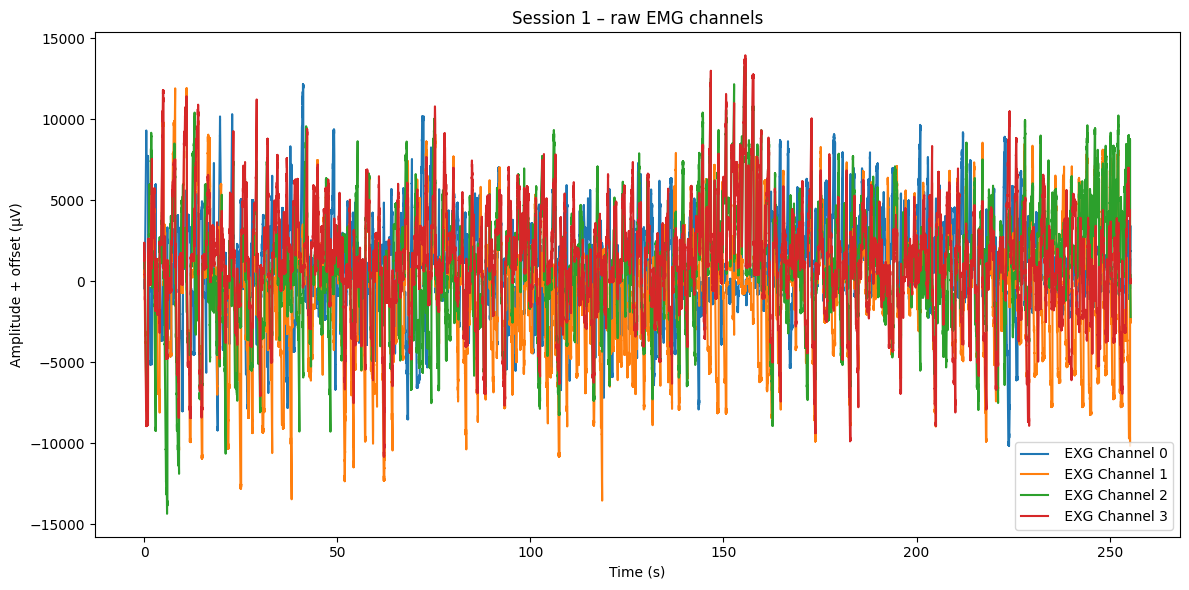

In [26]:
fs = 200  # sampling frequency; Hz
t = np.arange(len(df)) / fs

ch_names = [
    " EXG Channel 0",  # EXG: “excitatory” / “external biopotential” channels; OpenBCI label
    " EXG Channel 1",
    " EXG Channel 2",
    " EXG Channel 3",
]

plt.figure(figsize=(12,6))
offset = 0
for name in ch_names:
    plt.plot(t, df[name] + offset, label=name)
    offset += 500

plt.xlabel("Time (s)")
plt.ylabel("Amplitude + offset (µV)")
plt.title("Session 1 – raw EMG channels")
plt.legend()
plt.tight_layout()
plt.show()

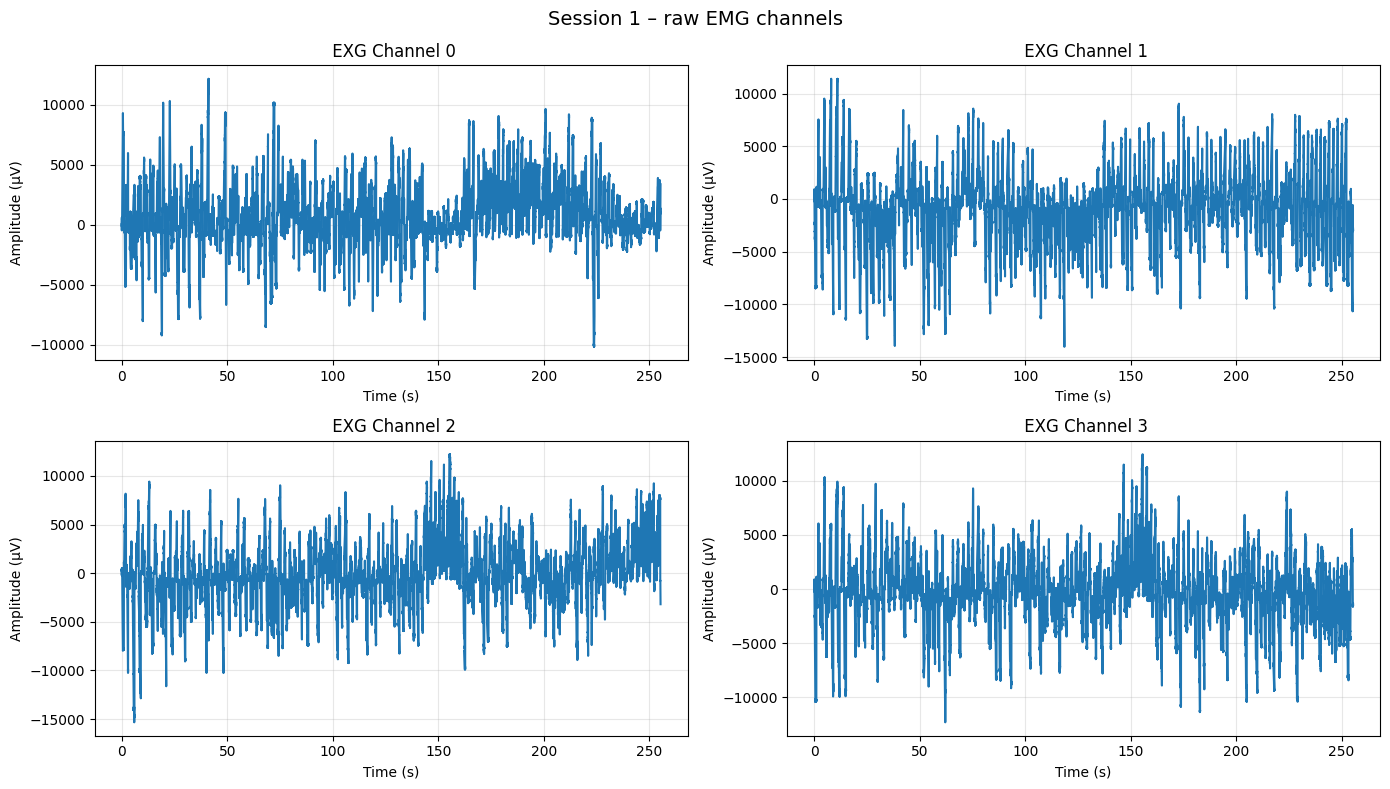

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, name in enumerate(ch_names):
    axes[i].plot(t, df[name])
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Amplitude (µV)")
    axes[i].set_title(name)
    axes[i].grid(True, alpha=0.3)

fig.suptitle("Session 1 – raw EMG channels", fontsize=14)
plt.tight_layout()
plt.show()

### Add gesture labels based on the timings described above

In [27]:
fs = 200.0
n_samples = len(df)

# time vector: one time stamp per sample, in seconds
t = np.arange(n_samples) / fs

labels = np.full(n_samples, "rest", dtype=object)

In [28]:
def mark_interval(start_s: float, end_s: float, name: str):
    idx = (t >= start_s) & (t < end_s)
    labels[idx] = name

In [29]:
# Timings (in seconds) from Session 1
mark_interval(5, 60, "pinch1")
mark_interval(60, 65, "rest")
mark_interval(65, 120, "pinch2")
mark_interval(120, 125, "rest")
mark_interval(125, 180, "pinch1_hold")
mark_interval(180, 185, "rest")
mark_interval(185, 240, "pinch2_hold")
mark_interval(240, 255, "rest")

In [30]:
df["label"] = labels

In [31]:
# see how many samples we have of each class
df["label"].value_counts()

label
pinch1         11000
pinch2         11000
pinch1_hold    11000
pinch2_hold    11000
rest            7087
Name: count, dtype: int64

In [32]:
# mean absolute EMG per label and channel
ch_names = [
    " EXG Channel 0",
    " EXG Channel 1",
    " EXG Channel 2",
    " EXG Channel 3",
]

feature_by_label = (df.groupby("label")[ch_names].apply(lambda x: x.abs().mean()))
feature_by_label

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3
label,,,,
pinch1,2233.641567,3468.579792,2875.089133,2649.141793
pinch1_hold,1933.525468,2680.970260,2895.355766,2731.104556
pinch2,2227.838740,2825.359195,2625.253102,2351.868797
pinch2_hold,2337.883570,2654.501539,2096.583237,2409.930480
rest,1593.759833,3807.401579,2806.550521,2875.326334


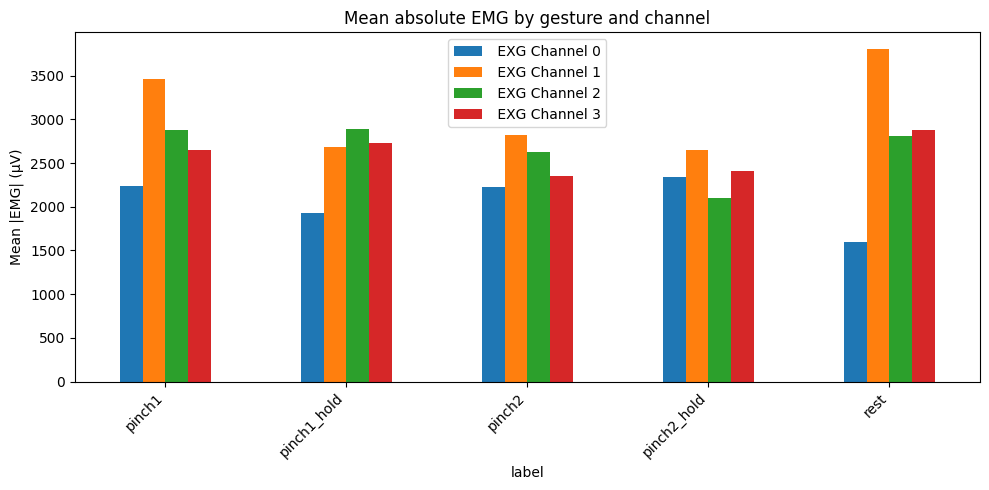

In [36]:
ax = feature_by_label.plot(kind="bar", figsize=(10, 5))
ax.set_ylabel("Mean |EMG| (µV)")  # average absolute amplitude
ax.set_title("Mean absolute EMG by gesture and channel")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()